In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import os
import torchio as tio
from options.test_options import TestOptions
import numpy as np
from models.models import create_model
from util.visualizer import Visualizer
from util import html
import torch
#from models.networks import Dense3DSpatialTransformer
from medipy.metrics import dice
import torch.nn.functional as F
import nrrd
import nibabel as nib
from scipy.ndimage import zoom
%matplotlib inline

In [2]:
class Params(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __getstate__(self):
        return self

    def __setstate__(self, state):
        self.update(state)

    def copy(self, **extra_params):
        return Params(**self, **extra_params)

In [3]:
datapath = os.path.join('./Task02_Heart/generated_pairs_16/images/')
dataFiles  = sorted(os.listdir(datapath))
dataFiles = [i for i in dataFiles if not i.startswith('.')]
dataFiles = dataFiles[int(0.8*len(dataFiles)):]

In [4]:
case_name = 'la_003'

In [5]:
len(dataFiles)

4

In [19]:
opt = Params(
    nThreads = 1,
    batchSize = 1,
    isTrain = False,
    dataroot = './Task02_Heart/evaluation_pairs_16/images/' + case_name,
    labelroot = './Task02_Heart/generated_pairs_16/images/' + case_name, 
    gpu_ids = [0],          
    name_G = 'CycleMorph_heart_seg', 
    name = 'CycleMorph_heart_seg', 
    name_S = 'CycleMorph_heart_seg', 
    model = 'cycleregister',
    init_type = 'normal',
    continue_train = False,
    which_model_netS = 'unet',
    which_model_netG = 'registnet',              
    inputSize = (128,128,128), 
    fineSize = (128,128,128),  
    input_nc = 2,                
    encoder_nc = [16,32,32,32,32],
    decoder_nc = [32,32,32,16,16,1],
    which_epoch_S = 20,
    which_epoch_G = 20,
    which_epoch = 20,
    display_id = 0,
    display_winsize = 192,
    display_port = 8097,
    model_type = 'seg_align',
    phase = 'test',
    checkpoints_dir = './checkpoints/CycleMorph_heart_segalign_16_1225/', 
    checkpoints_dir_G = './checkpoints/CycleMorph_heart_segalign_16_1225/', 
    checkpoints_dir_S = './checkpoints/CycleMorph_heart_segalign_16_1225/', 
    results_dir = './results/CycleMorph_heart_segalign/')
print(opt)

{'nThreads': 1, 'batchSize': 1, 'isTrain': False, 'dataroot': './Task02_Heart/evaluation_pairs_16/images/la_030', 'labelroot': './Task02_Heart/generated_pairs_16/images/la_030', 'gpu_ids': [0], 'name_G': 'CycleMorph_heart_seg', 'name': 'CycleMorph_heart_seg', 'name_S': 'CycleMorph_heart_seg', 'model': 'cycleregister', 'init_type': 'normal', 'continue_train': False, 'which_model_netS': 'unet', 'which_model_netG': 'registnet', 'inputSize': (128, 128, 128), 'fineSize': (128, 128, 128), 'input_nc': 2, 'encoder_nc': [16, 32, 32, 32, 32], 'decoder_nc': [32, 32, 32, 16, 16, 1], 'which_epoch_S': 20, 'which_epoch_G': 20, 'which_epoch': 20, 'display_id': 0, 'display_winsize': 192, 'display_port': 8097, 'model_type': 'seg_align', 'phase': 'test', 'checkpoints_dir': './checkpoints/CycleMorph_heart_segalign_16_1225/', 'checkpoints_dir_G': './checkpoints/CycleMorph_heart_segalign_16_1225/', 'checkpoints_dir_S': './checkpoints/CycleMorph_heart_segalign_16_1225/', 'results_dir': './results/CycleMorph_

In [20]:
def _toTorchFloatTensor(img):
    img = torch.from_numpy(img.copy())
    return img

model_regist = create_model(opt)
visualizer = Visualizer(opt)

# create website
web_dir = os.path.join(opt.results_dir, opt.name, '%s_%s' % (opt.phase, opt.which_epoch))
webpage = html.HTML(web_dir, 'Experiment = %s, Phase = %s, Epoch = %s' %
                    (opt.name, opt.phase, opt.which_epoch))

cycleregister
model type: seg_align
initialization method [normal]
AvgPool3d
Conv3d
AvgPool3d
ReLU
Sequential
Conv3d
AvgPool3d
ReLU
Sequential
Conv3d
AvgPool3d
ReLU
Sequential
Linear
ReLU
Sequential
Linear
Linear
registerNet
DataParallel
registerNeter
model [cycleregister] was created


In [21]:
def rot2eul(R):
    beta = -np.arcsin(R[2,0])
    alpha = np.arctan2(R[2,1]/np.cos(beta),R[2,2]/np.cos(beta))
    gamma = np.arctan2(R[1,0]/np.cos(beta),R[0,0]/np.cos(beta))
    return np.array((alpha, beta, gamma))
def test(dataFile,labelFile,regist_cnt=3):
    train_transforms = tio.Compose([tio.RescaleIntensity(out_min_max=(0, 1))                             
    ])
    print('test volume = %s' % (dataFile))
    label = nib.load(labelFile)
    labels = np.array([1,2])
    datafiles = [dataFile]
    originDice = np.zeros((len(datafiles), labels.shape[0]))
    registDice = np.zeros((len(datafiles), labels.shape[0]))
    readdata1 = np.array(label.dataobj)
    #atlas = np.load(os.path.join(opt.labelroot, 'atlas_norm.npz'))
    label_vol = zoom(np.array(readdata1),(1/2,1/2,1/2),order=1)
    label_vol = np.expand_dims(label_vol,axis=0)
    img= nib.load(dataFile)
    readdata1 = np.array(img.dataobj)
    data = np.expand_dims(readdata1,axis=0)
    data = zoom(data,(1,1/2,1/2,1/2),order=1)
    data_vol = train_transforms(tio.ScalarImage(tensor = data))[tio.DATA].float()
    label_vol = label_vol / (label_vol.max()*1.0)
    #label_vol = train_transforms(tio.ScalarImage(tensor =label_vol))[tio.DATA].float()

    test_dataA = data_vol.reshape(1, 1, 128, 128, 128)
    test_dataB = torch.tensor(label_vol.reshape((1, 1, 128, 128, 128))).float()
    batch_x = test_dataA
    batch_y = test_dataB
    ###################################################

    test_data = {'A': batch_x, 'B': batch_y,'M_A':batch_x, 'M_B':batch_y,'path': dataFile}
    model_regist.set_input(test_data)
    model_regist.test()
    visuals = model_regist.get_current_data()
    
    regist_flow = visuals['flow_A'].permute(0,4,1,2,3).cpu().float().numpy()

    regist_data = visuals['fake_B']
    regist_data = regist_data.cpu().float().numpy()[0, 0]
    regist_data = np.array(regist_data,dtype=float)
    label_vol = np.array(label_vol[0],dtype=float)
    origin_data = np.array(data_vol[0],dtype=float)
    pre_segA = torch.sigmoid(visuals['seg_A']).cpu().float().numpy()[0, 0]
    pre_segB = torch.sigmoid(visuals['seg_B']).cpu().float().numpy()[0, 0]
    regist_mask = F.grid_sample(torch.sigmoid(visuals['seg_A']), visuals['flow_A']).cpu().float().numpy()[0, 0]
    vals_regist, _ = dice(regist_data>0.1, label_vol>0.1,nargout=2)
    vals_origin, _ = dice(origin_data>0.1, label_vol>0.1,nargout=2)
    registDice[0] = vals_regist
    originDice[0] = vals_origin
    print(np.mean(vals_regist))
    print(np.mean(vals_origin))
    pre_theta = torch.unsqueeze(torch.concat([visuals['theta'],torch.tensor([[0,0,0,1]])],0),0)
    seg_pre = visuals['seg_A']
    for i in range(regist_cnt):
        batch_x = visuals['fake_B']
        batch_y = test_dataB
        test_data = {'A': batch_x, 'B': batch_y,'M_A':batch_x, 'M_B':batch_y,'path': dataFile}
        model_regist.set_input(test_data)
        model_regist.test()
        visuals = model_regist.get_current_data()

        regist_flow = visuals['flow_A'].permute(0,4,1,2,3).cpu().float().numpy()

        regist_data = visuals['fake_B']
        regist_data = regist_data.cpu().float().numpy()[0, 0]
        regist_data = np.array(regist_data,dtype=float)
        pre_theta = torch.bmm(torch.unsqueeze(torch.concat([visuals['theta'],torch.tensor([[0,0,0,1]])],0),0),pre_theta)
        vals_regist, _ = dice(regist_data>0.1, label_vol>0.1,nargout=2)
        vals_origin, _ = dice(origin_data>0.1, label_vol>0.1,nargout=2)


        
        #vals_regist, _ = dice(regist_mask>0.5, pre_segB>0.5,nargout=2)
        #vals_origin, _ = dice(pre_segA>0.5, pre_segB>0.5,nargout=2)
        print(np.mean(vals_regist))
        print(np.mean(vals_origin))
    alpha,beta,gamma = rot2eul(np.linalg.inv(pre_theta[0])[0:3, :])
    tx,ty,tz = pre_theta[0][0][2],pre_theta[0][1][2],pre_theta[0][2][2]
    print(-gamma,-beta,-alpha,-tz,-ty,-tx)
    grid = F.affine_grid(pre_theta[:, 0:3, :], seg_pre.size())
    regist_mask = F.grid_sample(torch.sigmoid(seg_pre).cpu(), grid).cpu().float().numpy()[0, 0]
    #regist_data = F.grid_sample(batch_x.cpu(), grid).cpu().float().numpy()[0, 0]
    return regist_data,grid,origin_data,label_vol,pre_segA,pre_segB,regist_mask,pre_theta

In [9]:
case_name = dataFiles[2]

In [10]:
case_name

'la_029'

In [11]:
mask = tio.ScalarImage(os.path.join('Task02_Heart','labelsTr',case_name+'.nii.gz'))
resample = tio.Resample((1,1,1),image_interpolation='nearest')
mask = resample(mask)
transform = tio.CropOrPad(
    (256, 256, 256),
)
mask = transform(mask).data
high_mask = mask
dataroot = './Task02_Heart/evaluation_pairs_16/images/' + case_name
labelroot = './Task02_Heart/generated_pairs_16/images/' + case_name
####### Image Pre-processing ##############################################
img_name = 'x.nii.gz'
dataFile= os.path.join(dataroot, img_name)
labelFile = os.path.join(labelroot, img_name)
aligned_img_x,regist_flow,image_x,gt_x,pre_segA_x,pre_segB_x,regist_mask_x,pre_theta = test(dataFile,labelFile,10)
eval_mask= nib.load(os.path.join('Task02_Heart','evaluation_pairs_16/masks/',case_name,img_name))
readdata1 = np.array(eval_mask.dataobj)
mask = np.expand_dims(readdata1,axis=0)
low_mask_x = zoom(mask,(1,1/2,1/2,1/2),order=1)
print('dice for low resolution mask x')
print(dice(np.array(pre_segA_x)>0.5, np.array(low_mask_x[0])>0.1,nargout=1))
print('dice for high resolution mask x')
print(dice(np.array(zoom(regist_mask_x,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1,nargout=1))

img_name = 'y.nii.gz'
dataFile= os.path.join(dataroot, img_name)
labelFile = os.path.join(labelroot, img_name)
aligned_img_y,regist_flow,image_y,gt_y,pre_segA_y,pre_segB_y,regist_mask_y,pre_theta = test(dataFile,labelFile,10)
eval_mask= nib.load(os.path.join('Task02_Heart','evaluation_pairs_16/masks/',case_name,img_name))
readdata1 = np.array(eval_mask.dataobj)
mask = np.expand_dims(readdata1,axis=0)
low_mask_y = zoom(mask,(1,1/2,1/2,1/2),order=1)
print('dice for low resolution mask y')
print(dice(np.array(pre_segA_y)>0.5, np.array(low_mask_y[0])>0.1,nargout=1))
print('dice for high resolution mask y')
print(dice(np.array(zoom(regist_mask_y,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1,nargout=1))

img_name = 'z.nii.gz'
dataFile= os.path.join(dataroot, img_name)
labelFile = os.path.join(labelroot, img_name)
aligned_img_z,regist_flow,image_z,gt_z,pre_segA_z,pre_segB_z,regist_mask_z,pre_theta = test(dataFile,labelFile,10)
eval_mask= nib.load(os.path.join('Task02_Heart','evaluation_pairs_16/masks/',case_name,img_name))
readdata1 = np.array(eval_mask.dataobj)
mask = np.expand_dims(readdata1,axis=0)
low_mask_z = zoom(mask,(1,1/2,1/2,1/2),order=1)
print('dice for low resolution mask z')
print(dice(np.array(pre_segA_z)>0.5, np.array(low_mask_z[0])>0.1,nargout=1))
print('dice for high resolution mask z')
print(dice(np.array(zoom(regist_mask_z,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1,nargout=1))

test volume = ./Task02_Heart/evaluation_pairs_16/images/la_029/x.nii.gz


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/home/hg119/.local/lib/python3.7/site-packages/unet/decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.

0.9858660135251336
1.0
0.979158773836923
1.0
0.9738800909048129
1.0
0.969212373694937
1.0
0.9650644215881442
1.0
0.9614767732176261
1.0
0.9581397212538739
1.0
0.9549533743178835
1.0
0.9522435357272117
1.0
0.9498800156066031
1.0
0.9475620390783535
1.0
0.0030273453 -0.0065199165 -0.010840361 tensor(-0.9999) tensor(-0.0108) tensor(0.0065)
dice for low resolution mask x
[0.89975644]
dice for high resolution mask x
[0.76846924]
test volume = ./Task02_Heart/evaluation_pairs_16/images/la_029/y.nii.gz
0.8127901944960996
0.7238770299730697
0.8469430972658492
0.7238770299730697
0.8598912771443371
0.7238770299730697
0.8621243137619801
0.7238770299730697
0.8631995198351395
0.7238770299730697
0.8639788937525333
0.7238770299730697
0.8646268803032449
0.7238770299730697
0.8650483865230594
0.7238770299730697
0.865371747400751
0.7238770299730697
0.8655438527242701
0.7238770299730697
0.8656480154147055
0.7238770299730697
0.07339685 0.057481516 -0.32083595 tensor(-0.9474) tensor(-0.3148) tensor(-0.0574)
d

In [48]:
print(dice(np.array(zoom(regist_mask_x,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.5,nargout=1))

[0.77625923]


In [49]:
image = tio.ScalarImage(os.path.join('Task02_Heart','imagesTr',case_name+'.nii.gz'))
resample = tio.Resample((1,1,1),image_interpolation='nearest')
image = resample(image)
transform = tio.CropOrPad(
    (256, 256, 256),
)
image = transform(image).data
high_reso_image = image

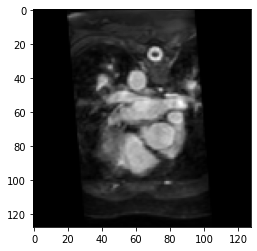

In [50]:
plt.imshow(image_y[:,65,:],cmap='gray')

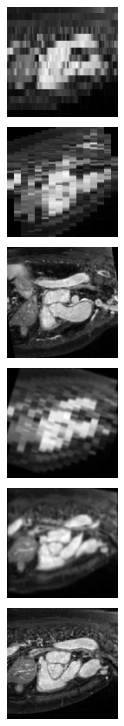

In [51]:
fig,a =  plt.subplots(6,1, figsize=(10,10))
a[0].imshow(image_x[:,:,65],cmap='gray')
#a[0].set_title('view1')
a[0].axis(False)
a[1].imshow(image_y[:,:,65],cmap='gray')
#a[1].set_title('view2')
a[1].axis(False)
a[2].imshow(image_z[:,:,65],cmap='gray')
#a[2].set_title('view3')
a[2].axis(False)
a[3].imshow(aligned_img_y[:,:,65],cmap='gray')
#a[1].set_title('view2')
a[3].axis(False)
a[4].imshow(aligned_img_z[:,:,65],cmap='gray')
#a[2].set_title('view3')
a[4].axis(False)
a[5].imshow(high_reso_image[0,:,:,130],cmap='gray')
#a[2].set_title('view3')
a[5].axis(False)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

(-0.5, 127.5, 127.5, -0.5)

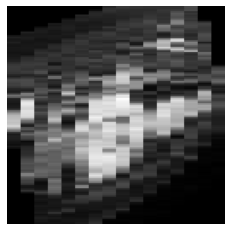

In [52]:
plt.figure()
plt.imshow(image_y[:,:,65],cmap='gray')
plt.axis(False)

In [ ]:
plt.figure()
plt.imshow(aligned_img_y[:,:,65],cmap='gray')
plt.axis(False)

In [ ]:
plt.figure()
plt.imshow(low_mask_x[0,:,:,65],cmap='gray')
plt.axis(False)

In [ ]:
plt.figure()
plt.imshow(gt_y[:,:,65],cmap='gray')
plt.axis(False)

In [ ]:
plt.figure()
plt.imshow(pre_segA_x[:,:,65],cmap='gray')

In [ ]:
from skimage import io, color
slice = 65
plt.figure(figsize=(8,5))
#image_show = aligned_img_x[:,:,slice]
image_show = image_x[:,:,slice]
#pre_show = np.array(np.array(zoom(high_mask[0],(1/2,1/2,1/2),order=1)[:,:,slice]>0.5))
pre_show = np.array(pre_segA_x[:,:,slice]>0.5)
plt.imshow(color.label2rgb(pre_show,image_show,colors=[(255,0,0)],alpha=0.0, bg_label=0, bg_color=None))
plt.grid(False)
plt.axis(False)
plt.show()

In [ ]:
from skimage import io, color
slice = 65
plt.figure(figsize=(8,5))
#image_show = aligned_img_x[:,:,slice]
image_show = gt_x[:,:,slice]
#pre_show = np.array(np.array(zoom(high_mask[0],(1/2,1/2,1/2),order=1)[:,:,slice]>0.5))
pre_show = np.array(regist_mask_x[:,:,slice]>0.5)
plt.imshow(color.label2rgb(pre_show,image_show,colors=[(255,0,0)],alpha=0.001, bg_label=0, bg_color=None))
plt.grid(False)
plt.axis(False)
plt.show()

In [13]:
transform = tio.CropOrPad(
    (256, 256, 256),
)
save_folder = 'test_results_heart_16'
regist_mask_x = tio.ScalarImage(os.path.join(save_folder,case_name,'pre_seg_x.nii.gz')).data
obj_x = zoom(np.array(regist_mask_x),(1,2,2,2),order=1)
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
def gaussian_filter(size):
    x = np.linspace(-size,size,2*size+1)
    gauss_x = gaussian(x,0,size/2)
    return gauss_x
save_folder = 'test_results_heart_16_1stage'
for i in range(len(dataFiles)):
    case_name = dataFiles[i]
    img= tio.ScalarImage(os.path.join('./Task02_Heart/gt_pairs_16/images',case_name,'x.nii.gz'))
    gt_x = np.array(torch.squeeze(transform(img).data))
    img= tio.ScalarImage(os.path.join('./Task02_Heart/gt_pairs_16/images',case_name,'y.nii.gz'))
    gt_y = np.array(torch.squeeze(transform(img).data))
    img = tio.ScalarImage(os.path.join('./Task02_Heart/gt_pairs_16/images',case_name,'z.nii.gz'))
    gt_z = np.array(torch.squeeze(transform(img).data))

    filter_size = 9
    x = gaussian_filter(filter_size)
    prob_x = np.zeros(obj_x.data.shape)
    for i in range(obj_x.data.shape[2]):
        for j in range(obj_x.data.shape[3]):
            prob_x[0,:,i,j] = np.convolve(x,np.array(gt_x[:,i,j]>0.5,dtype=float))[filter_size:-filter_size]
    prob_y = np.zeros(obj_x.data.shape)
    for i in range(obj_x.data.shape[1]):
        for j in range(obj_x.data.shape[3]):
            prob_y[0,i,:,j] = np.convolve(x,np.array(gt_y[i,:,j]>0.5,dtype=float))[filter_size:-filter_size]
    prob_z = np.zeros(obj_x.data.shape)
    for i in range(obj_x.data.shape[1]):
        for j in range(obj_x.data.shape[2]):
            prob_z[0,i,j,:] = np.convolve(x,np.array(gt_z[i,j,:]>0.5,dtype=float))[filter_size:-filter_size]
    if not os.path.exists(os.path.join(save_folder,case_name)):
        os.mkdir(os.path.join(save_folder,case_name))
    tio.ScalarImage(tensor=torch.Tensor(prob_x)).save(os.path.join(save_folder,case_name,'prob_x.nii.gz'))
    tio.ScalarImage(tensor=torch.Tensor(prob_y)).save(os.path.join(save_folder,case_name,'prob_y.nii.gz'))
    tio.ScalarImage(tensor=torch.Tensor(prob_z)).save(os.path.join(save_folder,case_name,'prob_z.nii.gz'))

([<matplotlib.axis.YTick at 0x7fb5e4171b90>,
 [Text(0, 0, '-gap'), Text(0, 9, '0'), Text(0, 18, 'gap')])

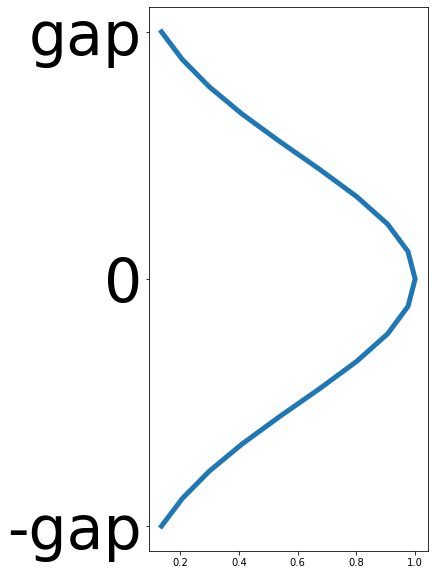

In [167]:
plt.figure(figsize=(5,10))
plt.plot(x,np.arange(len(x)),linewidth=5)
plt.yticks(fontsize=20)
plt.yticks([0,9,18],['-gap','0','gap'],fontsize=60)
#"plt.axis('off')

In [ ]:
image = tio.ScalarImage(os.path.join('Task02_Heart','imagesTr',case_name+'.nii.gz'))
resample = tio.Resample((1,1,1),image_interpolation='nearest')
image = resample(image)
transform = tio.CropOrPad(
    (256, 256, 256),
)
image = transform(image).data
high_reso_image = image

In [ ]:
from skimage import io, color
slice = 130
plt.figure(figsize=(8,5))
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(np.array(np.array(high_mask[0]))[:,:,slice]>0.5),image_show[0,:,:,slice],colors=[(255,0,0)],alpha=0.002, bg_label=0, bg_color=None))
plt.grid(False)
plt.axis(False)
plt.show()

In [ ]:
from skimage import io, color
slice = 130
plt.figure(figsize=(8,5))
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
slice_show = image_show[0,:,:,slice]
#pre_show = np.array((np.array(high_mask[0])[:,:,slice]>0.5))
pre_show = np.array(np.array(zoom(regist_mask_x,(2,2,2),order=1))[:,:,slice]>0.5)
plt.imshow(color.label2rgb(pre_show,slice_show,colors=[(255,0,0)],alpha=0.002, bg_label=0, bg_color=None))
plt.grid(False)
plt.axis(False)
plt.show()

In [ ]:
from skimage import io, color
slice = 130
plt.figure(figsize=(8,5))
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
slice_show = image_show[0,:,:,slice]
#pre_show = np.array((np.array(high_mask[0])[:,:,slice]>0.5))
pre_show = np.array(np.array(zoom(regist_mask_z,(2,2,2),order=1))[:,:,slice]>0.5)
plt.imshow(color.label2rgb(pre_show,slice_show,colors=[(255,0,0)],alpha=0.00, bg_label=0, bg_color=None))
plt.grid(False)
plt.axis(False)
plt.show()

In [ ]:
save_folder = 'test_results_heart'
if not os.path.exists(os.path.join(save_folder,case_name)):
    os.mkdir(os.path.join(save_folder,case_name))
tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(gt_x),0)).save(os.path.join(save_folder,case_name,'gt_x.nii.gz'))
tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(gt_y),0)).save(os.path.join(save_folder,case_name,'gt_y.nii.gz'))
tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(gt_z),0)).save(os.path.join(save_folder,case_name,'gt_z.nii.gz'))
tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(pre_segA_x),0)).save(os.path.join(save_folder,case_name,'pre_seg_x.nii.gz'))
tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(pre_segA_y),0)).save(os.path.join(save_folder,case_name,'pre_seg_y.nii.gz'))
tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(pre_segA_z),0)).save(os.path.join(save_folder,case_name,'pre_seg_z.nii.gz'))
tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(image_x),0)).save(os.path.join(save_folder,case_name,'image_x.nii.gz'))
tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(image_y),0)).save(os.path.join(save_folder,case_name,'image_y.nii.gz'))
tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(image_z),0)).save(os.path.join(save_folder,case_name,'image_z.nii.gz'))

In [15]:
def OS(mask_a,mask_b):
    mask_a = mask_a.flatten()
    mask_b = mask_b.flatten()
    return 1-np.sum(np.logical_and(mask_a,mask_b))/np.sum(mask_b)
def US(mask_a,mask_b):
    mask_a = mask_a.flatten()
    mask_b = mask_b.flatten()
    return 1-np.sum(np.logical_and(mask_a,mask_b))/np.sum(mask_a)
def RMS(mask_a,mask_b):
    return np.sqrt((OS(mask_a,mask_b)**2+US(mask_a,mask_b)**2)/2)
def AFI(mask_a,mask_b):
    return 0

In [22]:
low_dice_x_list = []
low_dice_y_list = []
low_dice_z_list = []
high_dice_x_list = []
high_dice_y_list = []
high_dice_z_list = []
OS_x_list = []
US_x_list = []
OS_y_list = []
US_y_list = []
OS_z_list = []
US_z_list = []
RMS_x_list = []
RMS_y_list = []
RMS_z_list = []
save_folder = 'test_results_heart_16_1stage'
for i in range(len(dataFiles)):
    case_name = dataFiles[i]
    dataroot = './Task02_Heart/evaluation_pairs_16/images/' + case_name
    labelroot = './Task02_Heart/generated_pairs_16/images/' + case_name
    mask = tio.ScalarImage(os.path.join('Task02_Heart','labelsTr',case_name+'.nii.gz'))
    resample = tio.Resample((1,1,1),image_interpolation='nearest')
    mask = resample(mask)
    transform = tio.CropOrPad(
        (256, 256, 256),
    )
    mask = transform(mask).data
    high_mask = mask

    ####### Image Pre-processing ##############################################
    img_name = 'x.nii.gz'
    dataFile= os.path.join(dataroot, img_name)
    labelFile = os.path.join(labelroot, img_name)
    aligned_img_x,regist_flow,image_x,gt_x,pre_segA_x,pre_segB_x,regist_mask_x,pre_theta = test(dataFile,labelFile)
    prob_x = tio.ScalarImage(os.path.join(save_folder,case_name,'prob_x.nii.gz')).data
    regist_prob_x = prob_x.float().numpy()[0]
    
    eval_mask= nib.load(os.path.join('Task02_Heart','./evaluation_pairs_16/masks/',case_name,img_name))
    readdata1 = np.array(eval_mask.dataobj)
    mask = np.expand_dims(readdata1,axis=0)
    low_mask_x = zoom(mask,(1,1/2,1/2,1/2),order=1)
    dice_low = dice(np.array(pre_segA_x)>0.5, np.array(low_mask_x[0])>0.1,nargout=1)
    low_dice_x_list.append(dice_low[0])
    print('dice for low resolution mask x')
    print(dice_low)
    print('dice for high resolution mask x')
    dice_high = dice(np.array(zoom(pre_segA_x,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1,nargout=1)
    high_dice_x_list.append(dice_high[0])
    print(dice_high)
    OS_x_list.append(OS(np.array(zoom(pre_segA_x,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))
    US_x_list.append(US(np.array(zoom(pre_segA_x,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))
    RMS_x_list.append(RMS(np.array(zoom(pre_segA_x,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))

    img_name = 'y.nii.gz'
    dataFile= os.path.join(dataroot, img_name)
    labelFile = os.path.join(labelroot, img_name)
    aligned_img_y,regist_flow,image_y,gt_y,pre_segA_y,pre_segB_y,regist_mask_y,pre_theta = test(dataFile,labelFile)
    
    prob_y = torch.unsqueeze(tio.ScalarImage(os.path.join(save_folder,case_name,'prob_y.nii.gz')).data,0)
    grid = F.affine_grid(pre_theta[:, 0:3, :], prob_y.size())
    regist_prob_y = F.grid_sample(prob_y, grid).float().numpy()[0, 0]
    
    eval_mask= nib.load(os.path.join('Task02_Heart','./evaluation_pairs_16/masks/',case_name,img_name))
    readdata1 = np.array(eval_mask.dataobj)
    mask = np.expand_dims(readdata1,axis=0)
    low_mask_y = zoom(mask,(1,1/2,1/2,1/2),order=1)
    dice_low = dice(np.array(pre_segA_y)>0.5, np.array(low_mask_y[0])>0.1,nargout=1)
    low_dice_y_list.append(dice_low[0])
    print('dice for low resolution mask y')
    print(dice_low)
    print('dice for high resolution mask y')
    dice_high = dice(np.array(zoom(regist_mask_y,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1,nargout=1)
    high_dice_y_list.append(dice_high[0])
    print(dice_high)
    OS_y_list.append(OS(np.array(zoom(regist_mask_y,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))
    US_y_list.append(US(np.array(zoom(regist_mask_y,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))
    RMS_y_list.append(OS(np.array(zoom(regist_mask_y,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))

    img_name = 'z.nii.gz'
    dataFile= os.path.join(dataroot, img_name)
    labelFile = os.path.join(labelroot, img_name)
    aligned_img_z,regist_flow,image_z,gt_z,pre_segA_z,pre_segB_z,regist_mask_z,pre_theta = test(dataFile,labelFile)
    
    prob_z = torch.unsqueeze(tio.ScalarImage(os.path.join(save_folder,case_name,'prob_z.nii.gz')).data,0)
    grid = F.affine_grid(pre_theta[:, 0:3, :], prob_z.size())
    regist_prob_z = F.grid_sample(prob_z, grid).float().numpy()[0, 0]
    
    eval_mask= nib.load(os.path.join('Task02_Heart','./evaluation_pairs_16/masks/',case_name,img_name))
    readdata1 = np.array(eval_mask.dataobj)
    mask = np.expand_dims(readdata1,axis=0)
    low_mask_z = zoom(mask,(1,1/2,1/2,1/2),order=1)
    dice_low = dice(np.array(pre_segA_z)>0.5, np.array(low_mask_z[0])>0.1,nargout=1)
    low_dice_z_list.append(dice_low[0])
    print('dice for low resolution mask z')
    print(dice_low)
    print('dice for high resolution mask z')
    dice_high = dice(np.array(zoom(regist_mask_z,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1,nargout=1)
    high_dice_z_list.append(dice_high[0])
    print(dice_high)
    OS_z_list.append(OS(np.array(zoom(regist_mask_z,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))
    US_z_list.append(US(np.array(zoom(regist_mask_z,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))
    RMS_z_list.append(OS(np.array(zoom(regist_mask_z,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))

    if not os.path.exists(os.path.join(save_folder,case_name)):
        os.mkdir(os.path.join(save_folder,case_name))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(gt_x),0)).save(os.path.join(save_folder,case_name,'gt_x.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(gt_y),0)).save(os.path.join(save_folder,case_name,'gt_y.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(gt_z),0)).save(os.path.join(save_folder,case_name,'gt_z.nii.gz'))
    
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(aligned_img_x),0)).save(os.path.join(save_folder,case_name,'aligned_img_x.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(aligned_img_y),0)).save(os.path.join(save_folder,case_name,'aligned_img_y.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(aligned_img_z),0)).save(os.path.join(save_folder,case_name,'aligned_img_z.nii.gz'))
    
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(regist_mask_x),0)).save(os.path.join(save_folder,case_name,'regist_mask_x.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(regist_mask_y),0)).save(os.path.join(save_folder,case_name,'regist_mask_y.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(regist_mask_z),0)).save(os.path.join(save_folder,case_name,'regist_mask_z.nii.gz'))
    
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(regist_prob_x),0)).save(os.path.join(save_folder,case_name,'regist_prob_x.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(regist_prob_y),0)).save(os.path.join(save_folder,case_name,'regist_prob_y.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(regist_prob_z),0)).save(os.path.join(save_folder,case_name,'regist_prob_z.nii.gz'))
    
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(pre_segA_x),0)).save(os.path.join(save_folder,case_name,'pre_seg_x.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(pre_segA_y),0)).save(os.path.join(save_folder,case_name,'pre_seg_y.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(pre_segA_z),0)).save(os.path.join(save_folder,case_name,'pre_seg_z.nii.gz'))
    
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(zoom(pre_segA_x,(2,2,2),order=1)*255),0)).save(os.path.join(save_folder,case_name,'resized_pre_seg_x.nii.gz'))
    
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(image_x),0)).save(os.path.join(save_folder,case_name,'image_x.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(image_y),0)).save(os.path.join(save_folder,case_name,'image_y.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(image_z),0)).save(os.path.join(save_folder,case_name,'image_z.nii.gz'))

test volume = ./Task02_Heart/evaluation_pairs_16/images/la_024/x.nii.gz
0.9475505064727132
1.0
0.9493830934556324
1.0
0.938594491443638
1.0
0.9333772746353199
1.0
-0.0019906461 0.00022055955 0.012482414 tensor(-0.9999) tensor(0.0125) tensor(-0.0002)
dice for low resolution mask x
[0.90326732]
dice for high resolution mask x
[0.81887332]
test volume = ./Task02_Heart/evaluation_pairs_16/images/la_024/y.nii.gz
0.8105671600891963
0.6645034172772613
0.8360962616076744
0.6645034172772613
0.8467581136139404
0.6645034172772613
0.8492354338145174
0.6645034172772613
0.0668495 0.1733326 -0.30173814 tensor(-0.9405) tensor(-0.2927) tensor(-0.1725)
dice for low resolution mask y
[0.85797847]
dice for high resolution mask y
[0.8156878]
test volume = ./Task02_Heart/evaluation_pairs_16/images/la_024/z.nii.gz
0.8298675963357193
0.7050220914861437
0.8379942254782303
0.7050220914861437
0.8428288841165354
0.7050220914861437
0.8438099328164158
0.7050220914861437
0.1440381 -0.2231953 0.16078804 tensor(-0.962

In [54]:
np.array(high_dice_z_list).mean()

0.8310783002061354

In [23]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
def gaussian_filter(size):
    x = np.linspace(-size,size,2*size+1)
    gauss_x = gaussian(x,0,size/2)
    return gauss_x

In [24]:
case_name = dataFiles[1]

In [25]:
fusion_dice_list =[]
OS_list = []
US_list = []
RMS_list = []
save_folder = 'test_results_heart_16_1stage'
for i in range(len(dataFiles)):
    case_name = dataFiles[i]
    if os.path.exists(os.path.join('./Task02_Heart/gt_pairs_16/images',case_name,'x.nii.gz')):
        case_name = dataFiles[i]
        dataroot = './Task02_Heart/evaluation_pairs_16/images/' + case_name
        labelroot = './Task02_Heart/generated_pairs_16/images/' + case_name
        mask = tio.ScalarImage(os.path.join('Task02_Heart','labelsTr',case_name+'.nii.gz'))
        resample = tio.Resample((1,1,1),image_interpolation='nearest')
        mask = resample(mask)
        transform = tio.CropOrPad(
            (256, 256, 256),
        )
        mask = transform(mask).data
        high_mask = mask


        regist_mask_x = tio.ScalarImage(os.path.join(save_folder,case_name,'pre_seg_x.nii.gz')).data
        regist_mask_y = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_mask_y.nii.gz')).data
        regist_mask_z = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_mask_z.nii.gz')).data

        obj_x = zoom(np.array(regist_mask_x),(1,2,2,2),order=1)
        obj_y = zoom(np.array(regist_mask_y),(1,2,2,2),order=1)
        obj_z = zoom(np.array(regist_mask_z),(1,2,2,2),order=1)

        prob_x = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_prob_x.nii.gz')).data.numpy()
        prob_y = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_prob_y.nii.gz')).data.numpy()
        prob_z = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_prob_z.nii.gz')).data.numpy()

        final_image = np.zeros(obj_x.size)
        prob_x_flatten = prob_x.flatten()
        prob_y_flatten = prob_y.flatten()
        prob_z_flatten = prob_z.flatten()
        map_x_flatten = obj_x.flatten()
        map_y_flatten = obj_y.flatten()
        map_z_flatten = obj_z.flatten()
        for idx in range(prob_x_flatten.size):
            if prob_x_flatten[idx]+prob_y_flatten[idx]+prob_z_flatten[idx]>0.4:
                ratio = (prob_x_flatten[idx]+prob_y_flatten[idx]+prob_z_flatten[idx])
                prob_x_flatten[idx], prob_y_flatten[idx], prob_z_flatten[idx] = \
                prob_x_flatten[idx]/ratio ,prob_y_flatten[idx]/ratio,prob_z_flatten[idx]/ratio 
                final_image[idx] = prob_x_flatten[idx]*map_x_flatten[idx]+prob_y_flatten[idx]*map_y_flatten[idx]+prob_z_flatten[idx]*map_z_flatten[idx]
        final_image = np.clip(np.round(final_image*1),0,a_max=1).reshape(prob_x.shape)
        dice_high_fusion =  dice(np.array(final_image[0])>0.5, np.array(high_mask[0])>0.1,nargout=1)
        OS_list.append(OS(np.array(final_image[0])>0.5, np.array(high_mask[0])>0.1))
        US_list.append(US(np.array(final_image[0])>0.5, np.array(high_mask[0])>0.1))
        RMS_list.append(RMS(np.array(final_image[0])>0.5, np.array(high_mask[0])>0.1))

        dice_before_x = dice(obj_x[0]>0.5, np.array(high_mask[0])>0.1,nargout=1)
        dice_before_y = dice(obj_y[0]>0.5, np.array(high_mask[0])>0.1,nargout=1)
        dice_before_z = dice(obj_z[0]>0.5, np.array(high_mask[0])>0.1,nargout=1)
        print('orignal_x dice: %f, orginal_y dice: %f, orginal_z dice: %.2f, final fusion dice: %.2f'%(dice_before_x,dice_before_y,dice_before_z,dice_high_fusion))
        fusion_dice_list.append(dice_high_fusion)
        
        tio.ScalarImage(tensor=torch.Tensor(final_image*255)).save(os.path.join(save_folder,case_name,'final_mask.nii.gz'))

orignal_x dice: 0.818873, orginal_y dice: 0.815688, orginal_z dice: 0.81, final fusion dice: 0.86
orignal_x dice: 0.806091, orginal_y dice: 0.729227, orginal_z dice: 0.78, final fusion dice: 0.82
orignal_x dice: 0.790429, orginal_y dice: 0.781604, orginal_z dice: 0.82, final fusion dice: 0.84
orignal_x dice: 0.800517, orginal_y dice: 0.823696, orginal_z dice: 0.86, final fusion dice: 0.87


In [26]:
np.array(fusion_dice_list).mean()

0.8488837847359163

In [80]:
np.array(RMS_list).mean()

0.13767890846639083

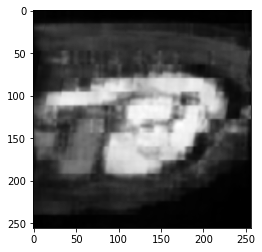

In [53]:
plt.imshow(final_image[0,:,:,128],cmap='gray')

## voting method

In [10]:
voting_dice_list =[]
for i in range(len(dataFiles)):
    case_name = dataFiles[i]
    if os.path.exists(os.path.join('./gt_pairs/images',case_name,'x.nii.gz')):
        mask = tio.ScalarImage(os.path.join('HGG',case_name,case_name+'_seg.nii.gz'))
        transform = tio.CropOrPad(
            (256, 256, 256),
        )
        mask = transform(mask).data
        high_mask = mask


        regist_mask_x = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_mask_x.nii.gz')).data
        regist_mask_y = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_mask_y.nii.gz')).data
        regist_mask_z = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_mask_z.nii.gz')).data
        
        obj_x = zoom(np.array(regist_mask_x),(1,2,2,2),order=1)
        obj_y = zoom(np.array(regist_mask_y),(1,2,2,2),order=1)
        obj_z = zoom(np.array(regist_mask_z),(1,2,2,2),order=1)

        regist_mask_x_final = np.array(obj_x>0.5,dtype=int)
        regist_mask_y_final = np.array(obj_y>0.5,dtype=int)
        regist_mask_z_final = np.array(obj_z>0.5,dtype=int)
        voting_mask = np.array((regist_mask_x_final + regist_mask_y_final + regist_mask_z_final)>2,dtype=int)
        
        dice_before_x = dice(obj_x[0]>0.5, np.array(high_mask[0])>0.1,nargout=1)
        dice_before_y = dice(obj_y[0]>0.5, np.array(high_mask[0])>0.1,nargout=1)
        dice_before_z = dice(obj_z[0]>0.5, np.array(high_mask[0])>0.1,nargout=1)
        dice_high_voting =  dice(np.array(voting_mask[0])>0.5, np.array(high_mask[0])>0.1,nargout=1)
        print('orignal_x dice: %f, orginal_y dice: %f, orginal_z dice: %.2f, final fusion dice: %.2f'%(dice_before_x,dice_before_y,dice_before_z,dice_high_voting))
        voting_dice_list.append(dice_high_voting)

In [ ]:
np.array(voting_dice_list).max()

## check overlap of regist x and y and z

In [ ]:
dice_overlap_list =[]
for i in range(len(dataFiles)):
    case_name = dataFiles[i]
    regist_mask_x = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_mask_y.nii.gz')).data
    regist_mask_y = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_mask_z.nii.gz')).data
    dice_high_overlap =  dice(np.array(regist_mask_x)>0.5, np.array(regist_mask_y)>0.5,nargout=1)
    dice_overlap_list.append(dice_high_overlap)

In [ ]:
np.array(dice_overlap_list).mean()

In [ ]:
np.array(dice_overlap_list).mean()

In [33]:
def drawContour(m,s,c,RGB):
    """Draw edges of contour 'c' from segmented image 's' onto 'm' in colour 'RGB'"""
    # Fill contour "c" with white, make all else black
    thisContour = s.point(lambda p:p==c and 255)
    # DEBUG: thisContour.save(f"interim{c}.png")

    # Find edges of this contour and make into Numpy array
    thisEdges   = thisContour.filter(ImageFilter.FIND_EDGES)
    thisEdgesN  = np.array(thisEdges)

    # Paint locations of found edges in color "RGB" onto "main"
    m[np.nonzero(thisEdgesN)] = RGB
    return m

In [ ]:
m = drawContour

In [36]:
image_show.shape

(1, 256, 256, 256)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


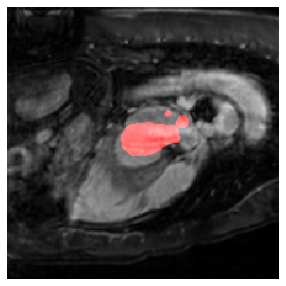

In [38]:
from skimage import io, color
slice = 120
plt.figure(figsize=(8,5))
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(np.array(zoom(regist_mask_z,(1,2,2,2),order=1))[0,:,:,slice]>0.5),image_show[0,:,:,slice],colors=[(255,0,0)],alpha=0.005, bg_label=0, bg_color=None))
plt.grid(False)
plt.axis(False)
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
slice = 150
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(final_image[0,slice]>0.5),image_show[0,slice],colors=[(255,0,0)],alpha=0.005, bg_label=0, bg_color=None))
plt.grid(False)
plt.show()

In [ ]:
from skimage import io, color
plt.figure(figsize=(8,5))
slice = 120
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(high_mask[0,:,:,slice]>0.5),image_show[0,:,:,slice],colors=[(255,0,0)],alpha=0.005, bg_label=0, bg_color=None))
plt.grid(False)
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(final_image[0,142]>0.5),image_show[0,142],colors=[(255,0,0)],alpha=0.005, bg_label=0, bg_color=None))
plt.grid(False)
plt.show()

In [ ]:
plt.figure()
plt.imshow(high_reso_image[0,141,:,:],cmap='gray')

In [ ]:
plt.figure()
plt.imshow(obj_x[0,141,:,:]>0.5,cmap='gray')

In [ ]:
print('dice for high resolution mask')
print(dice(np.array(final_image[0]), np.array(high_mask[0])>0.1,nargout=1))

In [ ]:
plt.figure()
plt.imshow(final_image[0,141,:,:]>0.5,cmap='gray')

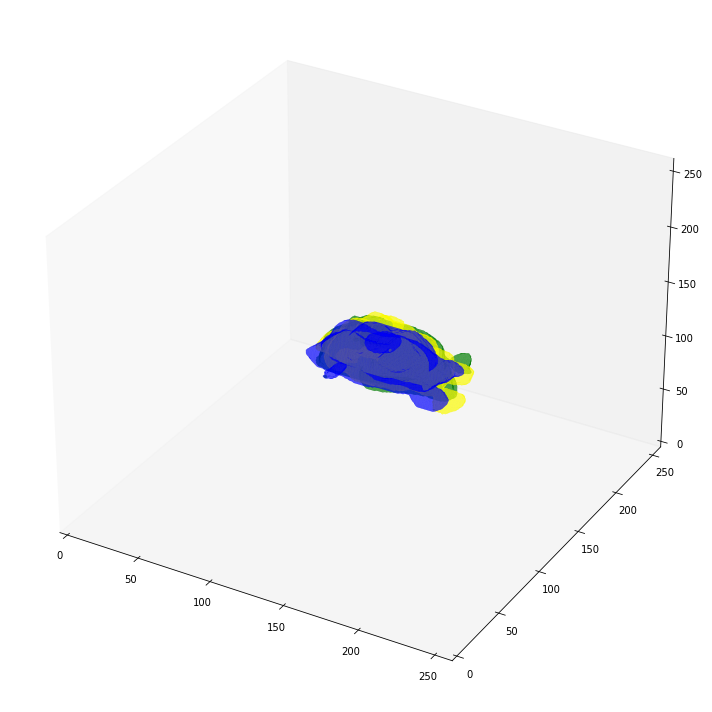

In [15]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
results_folder = 'test_results_heart_16'
# points is a 3D numpy array (n_points, 3) coordinates of a sphere
img_name = 'x.nii.gz'
case_name = 'la_030'

eval_mask= nib.load(os.path.join(results_folder,case_name,'pre_seg_x.nii.gz'))
readdata1 = np.array(eval_mask.dataobj)
mask = np.expand_dims(readdata1,axis=0)
mask = zoom(mask,(1,2,2,2),order=1)
verts, faces, norm, val = measure.marching_cubes(np.array(mask[0]>0.5).transpose(), allow_degenerate=True)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim(0, 256)
ax.set_ylim(0, 256) 
ax.set_zlim(0, 256)

mesh = Poly3DCollection(verts[faces],alpha=0.5)
face_color = ['green']*len(faces)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)


eval_mask= nib.load(os.path.join(results_folder,case_name,'pre_seg_y.nii.gz'))
readdata1 = np.array(eval_mask.dataobj)
mask = np.expand_dims(readdata1,axis=0)
mask = zoom(mask,(1,2,2,2),order=1)
verts, faces, norm, val = measure.marching_cubes(np.array(mask[0]>0.5).transpose(), allow_degenerate=True)

ax.set_xlim(0, 256)
ax.set_ylim(0, 256) 
ax.set_zlim(0, 256)

mesh = Poly3DCollection(verts[faces],alpha=0.5)
face_color = ['blue']*len(faces)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

eval_mask= nib.load(os.path.join(results_folder,case_name,'pre_seg_z.nii.gz'))
readdata1 = np.array(eval_mask.dataobj)
mask = np.expand_dims(readdata1,axis=0)
mask = zoom(mask,(1,2,2,2),order=1)
verts, faces, norm, val = measure.marching_cubes(np.array(mask[0]>0.5).transpose(), allow_degenerate=True)

ax.set_xlim(0, 256)
ax.set_ylim(0, 256) 
ax.set_zlim(0, 256)

mesh = Poly3DCollection(verts[faces],alpha=0.5)
face_color = ['yellow']*len(faces)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

plt.tight_layout()
ax.grid(False)
#ax.axis(False)
plt.show()

In [62]:
np.sqrt((0.098**2+0.103**2)/2)

0.10053108971855423

In [9]:
case_name = dataFiles[1]
results_folder = 'test_results_heart_16'

In [10]:
final_mask= nib.load(os.path.join(results_folder,case_name,'final_mask.nii.gz'))
readdata1 = np.array(final_mask.dataobj)
final_mask = np.expand_dims(readdata1,axis=0)
regist_mask_x = nib.load(os.path.join(results_folder,case_name,'regist_mask_x.nii.gz'))
readdata1 = np.array(regist_mask_x.dataobj)

regist_mask_x = np.expand_dims(readdata1,axis=0)
regist_mask_y= nib.load(os.path.join(results_folder,case_name,'regist_mask_y.nii.gz'))
readdata1 = np.array(regist_mask_y.dataobj)
regist_mask_y = np.expand_dims(readdata1,axis=0)
regist_mask_z= nib.load(os.path.join(results_folder,case_name,'regist_mask_z.nii.gz'))
readdata1 = np.array(regist_mask_z.dataobj)
regist_mask_z = np.expand_dims(readdata1,axis=0)

seg_mask_x = nib.load(os.path.join(results_folder,case_name,'pre_seg_x.nii.gz'))
readdata1 = np.array(seg_mask_x.dataobj)
seg_mask_x = np.expand_dims(readdata1,axis=0)
seg_mask_x = zoom(seg_mask_x,(1,2,2,2),order=1)
seg_mask_y= nib.load(os.path.join(results_folder,case_name,'pre_seg_y.nii.gz'))
readdata1 = np.array(seg_mask_y.dataobj)
seg_mask_y = np.expand_dims(readdata1,axis=0)
seg_mask_z= nib.load(os.path.join(results_folder,case_name,'pre_seg_z.nii.gz'))
readdata1 = np.array(seg_mask_z.dataobj)
seg_mask_z = np.expand_dims(readdata1,axis=0)

image = tio.ScalarImage(os.path.join('Task02_Heart','imagesTr',case_name+'.nii.gz'))
resample = tio.Resample((1,1,1),image_interpolation='nearest')
image = resample(image)
transform = tio.CropOrPad(
    (256, 256, 256),
)
image = transform(image).data
high_reso_image = image


mask = tio.ScalarImage(os.path.join('Task02_Heart','labelsTr',case_name+'.nii.gz'))
resample = tio.Resample((1,1,1),image_interpolation='nearest')
mask = resample(mask)
transform = tio.CropOrPad(
    (256, 256, 256),
)
mask = transform(mask).data
high_mask = mask


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


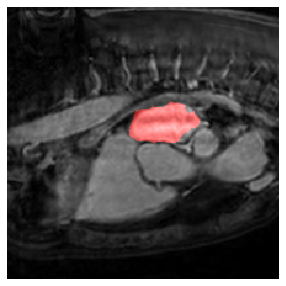

In [14]:
from skimage import io, color
slice = 148
plt.figure(figsize=(8,5))
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(np.array(final_mask[0])[:,:,slice]>0.5),image_show[0,:,:,slice],colors=[(255,0,0)],alpha=0.002, bg_label=0, bg_color=None))
plt.grid(False)
plt.axis(False)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


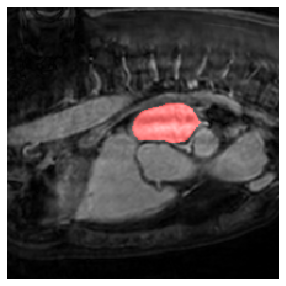

In [16]:
from skimage import io, color
slice = 148
plt.figure(figsize=(8,5))
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(np.array(high_mask[0])[:,:,slice]>0.5),image_show[0,:,:,slice],colors=[(255,0,0)],alpha=0.002, bg_label=0, bg_color=None))
plt.grid(False)
plt.axis(False)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


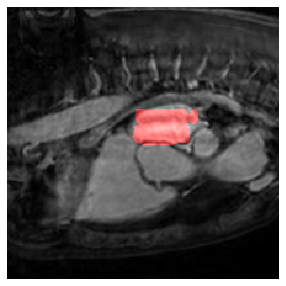

In [13]:
from skimage import io, color
slice = 128
plt.figure(figsize=(8,5))
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)

plt.imshow(color.label2rgb(np.array(np.array(seg_mask_x[0])[:,:,slice]>0.5),image_show[0,:,:,slice],colors=[(255,0,0)],alpha=0.002, bg_label=0, bg_color=None))
plt.grid(False)
plt.axis(False)
plt.show()

In [38]:
from skimage import io, color
slice = 130
plt.figure(figsize=(8,5))
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(np.array(final_mask[0])[:,:,slice]>0.5),image_show[0,:,:,slice],colors=[(255,0,0)],alpha=0.002, bg_label=0, bg_color=None))
plt.grid(False)
plt.axis(False)
plt.show()

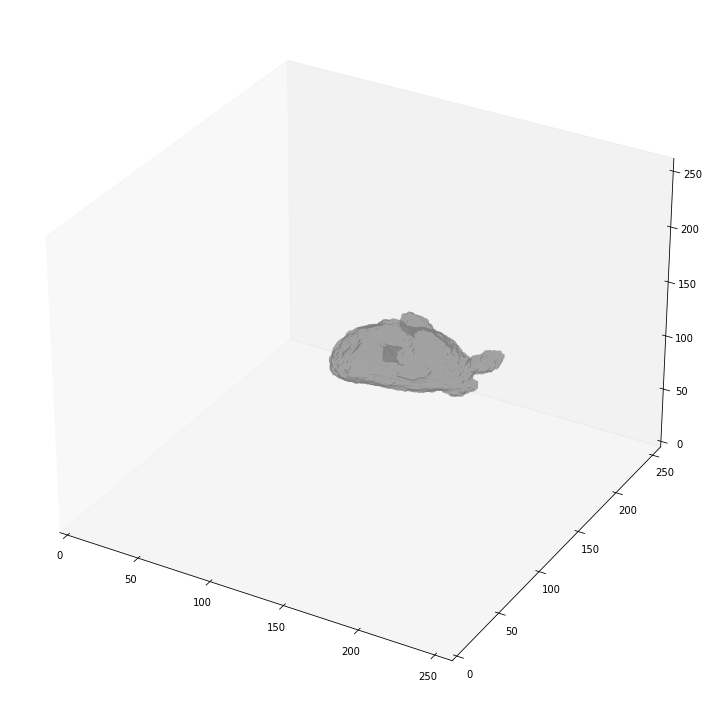

In [22]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

mask = tio.ScalarImage(os.path.join('Task02_Heart','labelsTr',case_name+'.nii.gz'))
resample = tio.Resample((1,1,1),image_interpolation='nearest')
mask = resample(mask)
transform = tio.CropOrPad(
    (256, 256, 256),
)
mask = transform(mask).data
high_mask = mask
verts, faces, norm, val = measure.marching_cubes(np.array(high_mask[0]>0.5).transpose(), allow_degenerate=True)
mesh = Poly3DCollection(verts[faces],alpha=0.5)
face_color = ['gray']*len(faces)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)


ax.set_xlim(0, 256)
ax.set_ylim(0, 256) 
ax.set_zlim(0, 256)

plt.tight_layout()
ax.grid(False)
#ax.axis()
plt.show()

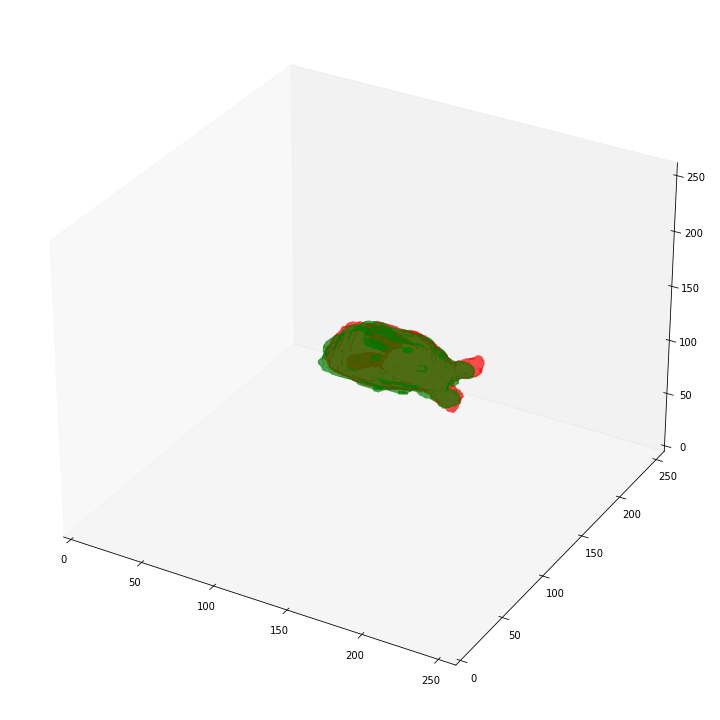

In [30]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
results_folder = 'test_results_heart_16'
# points is a 3D numpy array (n_points, 3) coordinates of a sphere
img_name = 'final_mask.nii.gz'
case_name = 'la_030'

eval_mask= nib.load(os.path.join(results_folder,case_name,'final_mask.nii.gz'))
readdata1 = np.array(eval_mask.dataobj)
mask = np.expand_dims(readdata1,axis=0)
verts, faces, norm, val = measure.marching_cubes(np.array(mask[0]>0.5).transpose(), allow_degenerate=True)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

mesh = Poly3DCollection(verts[faces],alpha=0.5)
face_color = ['green']*len(faces)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

mask = tio.ScalarImage(os.path.join('Task02_Heart','labelsTr',case_name+'.nii.gz'))
resample = tio.Resample((1,1,1),image_interpolation='nearest')
mask = resample(mask)
transform = tio.CropOrPad(
    (256, 256, 256),
)
mask = transform(mask).data
high_mask = mask
verts, faces, norm, val = measure.marching_cubes(np.array(high_mask[0]>0.5).transpose(), allow_degenerate=True)
mesh = Poly3DCollection(verts[faces],alpha=0.5)
face_color = ['red']*len(faces)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)


ax.set_xlim(0, 256)
ax.set_ylim(0, 256) 
ax.set_zlim(0, 256)

plt.tight_layout()
ax.grid(False)
#ax.axis(False)
plt.show()

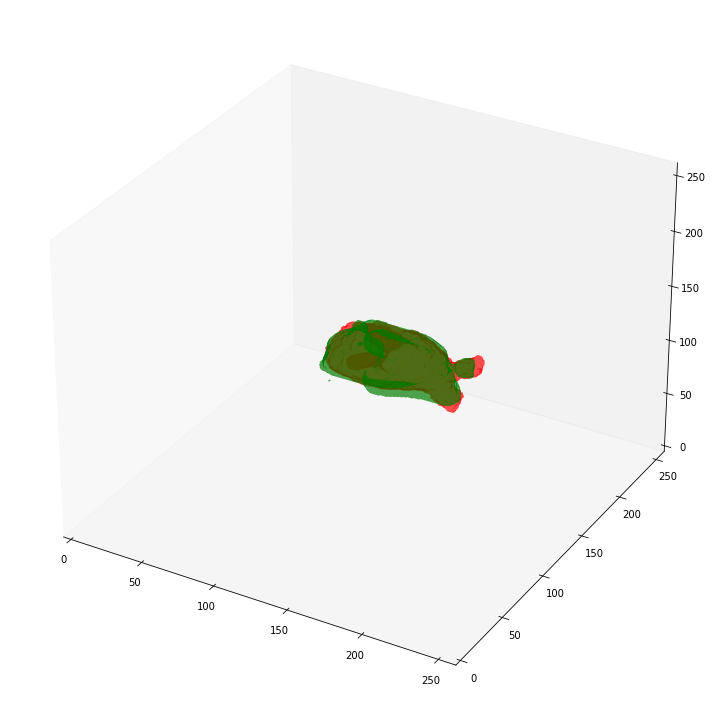

In [31]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
results_folder = 'test_results_heart_16'
# points is a 3D numpy array (n_points, 3) coordinates of a sphere
img_name = 'final_mask.nii.gz'
case_name = 'la_030'

eval_mask= nib.load(os.path.join(results_folder,case_name,'regist_mask_x.nii.gz'))
readdata1 = np.array(eval_mask.dataobj)
mask = np.expand_dims(readdata1,axis=0)
mask = zoom(mask,(1,2,2,2),order=1)
verts, faces, norm, val = measure.marching_cubes(np.array(mask[0]>0.5).transpose(), allow_degenerate=True)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

mesh = Poly3DCollection(verts[faces],alpha=0.5)
face_color = ['green']*len(faces)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

mask = tio.ScalarImage(os.path.join('Task02_Heart','labelsTr',case_name+'.nii.gz'))
resample = tio.Resample((1,1,1),image_interpolation='nearest')
mask = resample(mask)
transform = tio.CropOrPad(
    (256, 256, 256),
)
mask = transform(mask).data
high_mask = mask
verts, faces, norm, val = measure.marching_cubes(np.array(high_mask[0]>0.5).transpose(), allow_degenerate=True)
mesh = Poly3DCollection(verts[faces],alpha=0.5)
face_color = ['red']*len(faces)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)


ax.set_xlim(0, 256)
ax.set_ylim(0, 256) 
ax.set_zlim(0, 256)

plt.tight_layout()
ax.grid(False)
#ax.axis(False)
plt.show()

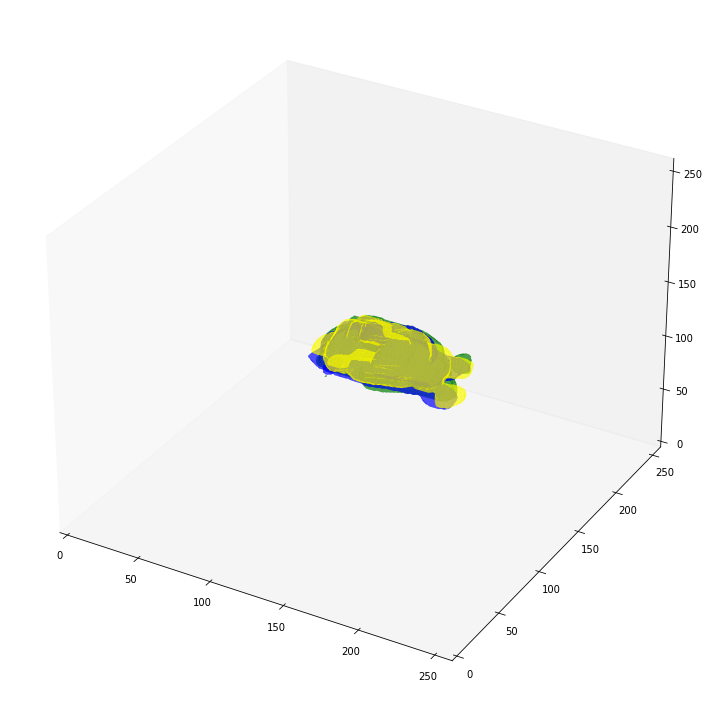

In [24]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
results_folder = 'test_results_heart_16'
# points is a 3D numpy array (n_points, 3) coordinates of a sphere
case_name = 'la_030'

eval_mask= nib.load(os.path.join(results_folder,case_name,'regist_mask_x.nii.gz'))
readdata1 = np.array(eval_mask.dataobj)
mask = np.expand_dims(readdata1,axis=0)
mask = zoom(mask,(1,2,2,2),order=1)
verts, faces, norm, val = measure.marching_cubes(np.array(mask[0]>0.5).transpose(), allow_degenerate=True)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim(0, 256)
ax.set_ylim(0, 256) 
ax.set_zlim(0, 256)

mesh = Poly3DCollection(verts[faces],alpha=0.5)
face_color = ['green']*len(faces)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)


eval_mask= nib.load(os.path.join(results_folder,case_name,'regist_mask_y.nii.gz'))
readdata1 = np.array(eval_mask.dataobj)
mask = np.expand_dims(readdata1,axis=0)
mask = zoom(mask,(1,2,2,2),order=1)
verts, faces, norm, val = measure.marching_cubes(np.array(mask[0]>0.5).transpose(), allow_degenerate=True)

ax.set_xlim(0, 256)
ax.set_ylim(0, 256) 
ax.set_zlim(0, 256)

mesh = Poly3DCollection(verts[faces],alpha=0.5)
face_color = ['blue']*len(faces)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

eval_mask= nib.load(os.path.join(results_folder,case_name,'regist_mask_z.nii.gz'))
readdata1 = np.array(eval_mask.dataobj)
mask = np.expand_dims(readdata1,axis=0)
mask = zoom(mask,(1,2,2,2),order=1)
verts, faces, norm, val = measure.marching_cubes(np.array(mask[0]>0.5).transpose(), allow_degenerate=True)

ax.set_xlim(0, 256)
ax.set_ylim(0, 256) 
ax.set_zlim(0, 256)

mesh = Poly3DCollection(verts[faces],alpha=0.5)
face_color = ['yellow']*len(faces)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

plt.tight_layout()
ax.grid(False)
#ax.axis(False)
plt.show()

In [7]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# points is a 3D numpy array (n_points, 3) coordinates of a sphere

verts, faces, norm, val = measure.marching_cubes(np.array(final_image[0]>0), allow_degenerate=True)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim(np.min(verts[:,0]), np.max(verts[:,0]))
ax.set_ylim(np.min(verts[:,1]), np.max(verts[:,1])) 
ax.set_zlim(np.min(verts[:,2]), np.max(verts[:,2]))

mesh = Poly3DCollection(verts[faces],alpha=0.4)
face_color = ['r']*len(faces)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)
plt.tight_layout()
plt.show()

NameError: name 'final_image' is not defined

In [ ]:
regist_mask_x_final = np.array(regist_mask_x>0.5,dtype=int)
regist_mask_y_final = np.array(regist_mask_y>0.5,dtype=int)
regist_mask_z_final = np.array(regist_mask_z>0.5,dtype=int)

In [ ]:
fusion_mask = np.array((regist_mask_x_final + regist_mask_y_final + regist_mask_z_final)>2,dtype=int)

In [ ]:
plt.figure()
plt.imshow(fusion_mask[35,:,:]>0.1,cmap='gray')

In [ ]:
plt.figure()
plt.imshow(aligned_img_z[35,:,:],cmap='gray')

In [ ]:
plt.figure()
plt.imshow(regist_mask_z[35,:,:],cmap='gray')

In [ ]:
print('dice for high resolution mask z')
print(dice(np.array(fusion_mask)>0.5, np.array(high_mask[0])>0.1,nargout=1))

In [ ]:
point_x,point_y,point_z = np.where(label_vol>0)
X_fix = np.dot(np.concatenate((point_x.reshape(-1,1),point_y.reshape(-1,1),point_z.reshape(-1,1)),axis=1),spacing)
point_x,point_y,point_z = np.where(origin_data>0)
X_mov = np.dot(np.concatenate((point_x.reshape(-1,1),point_y.reshape(-1,1),point_z.reshape(-1,1)),axis=1),spacing)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
X_fix = X_fix[::10]
X_mov = X_mov[::10]
ax.scatter(X_fix[:,0],X_fix[:,1],X_fix[:,2],alpha=0.5,c='r')
ax.scatter(X_mov[:,0],X_mov[:,1],X_mov[:,2],alpha=0.5,c='b')
ax.set_box_aspect([1,1,1])

In [ ]:
dice(final_image>0, np.array(gt_seg)>0,nargout=1)

In [ ]:
dice(np.array(final_image,dtype=int), np.array(gt_seg),nargout=1)

In [ ]:
np.sum(np.array(gt_x)==3)

In [ ]:
dice(np.array(mask_z)>0, np.array(gt_seg)>0,nargout=1)

In [ ]:
plt.figure()
plt.imshow(gt_seg[0,:,:,70],cmap='gray')

In [ ]:
plt.figure()
plt.imshow(obj_final[0,:,:,70],cmap='gray')

In [ ]:
plt.figure()
plt.imshow(gt_x[100,:,:]>0,cmap='gray')

In [ ]:
## compare with gt
resample = tio.Resample((5,1,1),image_interpolation='nearest')
resampled_mask_x = resample(mask)
resample = tio.Resample((1,1,1),image_interpolation='nearest')
mask_x = resample(resampled_mask_x).data
resample = tio.Resample((1,5,1),image_interpolation='nearest')
resampled_mask_y = resample(mask)
resample = tio.Resample((1,1,1),image_interpolation='nearest')
mask_y = resample(resampled_mask_y).data
resample = tio.Resample((1,1,5),image_interpolation='nearest')
resampled_mask_z = resample(mask)
resample = tio.Resample((1,1,1),image_interpolation='nearest')
mask_z = resample(resampled_mask_z).data

In [ ]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# points is a 3D numpy array (n_points, 3) coordinates of a sphere

verts, faces, norm, val = measure.marching_cubes(np.array(final_image[0]>0), allow_degenerate=True)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim(np.min(verts[:,0]), np.max(verts[:,0]))
ax.set_ylim(np.min(verts[:,1]), np.max(verts[:,1])) 
ax.set_zlim(np.min(verts[:,2]), np.max(verts[:,2]))

mesh = Poly3DCollection(verts[faces],alpha=0.4)
face_color = ['r']*len(faces)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

verts, faces, norm, val = measure.marching_cubes(np.array(gt_seg[0]>0), allow_degenerate=True)

ax.set_xlim(np.min(verts[:,0]), np.max(verts[:,0]))
ax.set_ylim(np.min(verts[:,1]), np.max(verts[:,1])) 
ax.set_zlim(np.min(verts[:,2]), np.max(verts[:,2]))

mesh = Poly3DCollection(verts[faces],alpha=0.4)
#mesh.set_facecolor('r')
#mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

plt.tight_layout()
plt.show()

In [ ]:
obj_z.shape

In [ ]:
point_x,point_y,point_z = np.where(obj_z[0][0]>0)
X_fix = np.dot(np.concatenate((point_x.reshape(-1,1),point_y.reshape(-1,1),point_z.reshape(-1,1)),axis=1),spacing)
point_x,point_y,point_z = np.where(gt_seg[0]>0)
X_mov = np.dot(np.concatenate((point_x.reshape(-1,1),point_y.reshape(-1,1),point_z.reshape(-1,1)),axis=1),spacing)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
X_fix = X_fix[::10] - 32
X_mov = X_mov[::10] - 32
ax.scatter(X_fix[:,0],X_fix[:,1],X_fix[:,2],alpha=0.2,c='r')
#ax.plot_surface(X_fix[:,0],X_fix[:,1],X_fix[:,2],alpha=0.5,c='r')
ax.scatter(X_mov[:,0],X_mov[:,1],X_mov[:,2],alpha=0.2,c='b')
ax.set_box_aspect([1,1,1])

In [ ]:
img= nib.load('./generated_pairs_8/images/Brats18_2013_2_1/x.nii.gz')
gt_x = np.array(img.dataobj)
img= nib.load('./generated_pairs_8/images/Brats18_2013_2_1/y.nii.gz')
gt_y = np.array(img.dataobj)
img= nib.load('./generated_pairs_8/images/Brats18_2013_2_1/z.nii.gz')
gt_z = np.array(img.dataobj)

In [ ]:
plt.figure()
plt.imshow(gt_x[100,:,:],cmap='gray')

In [ ]:
plt.figure()
plt.imshow(gt_y[100,:,:],cmap='gray')

In [ ]:
plt.figure()
plt.imshow(gt_z[100,:,:],cmap='gray')